# **FAKE NEWS DETECTION USING DEEP LEARNING**

**Gyan Prakash  2017CSB1077\
Abhishek Kumar  2017MED1002**

**Note: All the data and necessary files can be found [here](https://drive.google.com/drive/folders/1CoMMec4Wo2gHR3LP4hCjEjtKPHhbcYU0?usp=sharing)

The evolution of the information and communication technologies has dramatically
increased the number of people with access to the Internet, which has changed the way the
information is consumed. As a consequence of the above, fake news has become one of the
major concerns because it is potential to destabilize governments, which makes them a
potential danger to modern society. Almost all the democratic countries have seen its effect
during elections. We want to build a system that can predict the potential fake news or article.

# CNN Model

The intuition behind this comes from the fact that, after having obtained the word embeddings , the
content to analyze is similar to an image, i.e a NxM matrix where N is the number of words and M is the embedding
dimension. Thus, when a convolutional layer is applied, it is possible to detect the different features defining an article
in the same way as border or shapes are in an image.

### Importing the **library**

In [0]:
import keras
from tensorflow.python.client import device_lib

Using TensorFlow backend.


In [0]:
import numpy as np
import pandas as pd
from collections import defaultdict
import re

from bs4 import BeautifulSoup

import sys
import os

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, Concatenate, Average, Maximum, Minimum, Add, Subtract
from keras.models import Model

In [0]:
MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 200000
EMBEDDING_DIM = 100

In [0]:
def clean_str(string):
    """
    Cleaning of dataset
    """
    string = re.sub(r"\\", "", string)    
    string = re.sub(r"\'", "", string)    
    string = re.sub(r"\"", "", string)    
    return string.strip().lower()

### Loading and preprocessing the data

In [0]:
#This data set is used for testing the accuracy of the trained model
data_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/fake_news_train_kaggle.csv')
#data_train.text[1]

In [0]:
# Input Data preprocessing
#data_train = pd.read_csv('data/train_Mixed.csv')
#data_train['label'] = data_train['label'].replace('FAKE',1)
#data_train['label'] = data_train['label'].replace('REAL',0)
def preprocess(data):
  print(data.columns)
  print('What the raw input data looks like:')
  #print(data[0])
  texts = []
  labels = []

  for i in range(data.text.shape[0]):
      text1 = data.title[i]
      text2 = data.text[i]
      text = str(text1) +""+ str(text2)
      texts.append(text)
      if data.label[i]<=0.5:
        temp=0
      else:
        temp=1
      labels.append(temp)

  tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
  tokenizer.fit_on_texts(texts)
  sequences = tokenizer.texts_to_sequences(texts)

  word_index = tokenizer.word_index
  print('Found %s unique tokens.' % len(word_index))
  return sequences, labels, word_index

In [0]:
# Pad input sequences
sequences, labels, word_index = preprocess(data_train)
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
labels = to_categorical(np.asarray(labels),num_classes = 2)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Index(['id', 'title', 'author', 'text', 'label'], dtype='object')
What the raw input data looks like:
Found 251876 unique tokens.
Shape of data tensor: (20800, 1000)
Shape of label tensor: (20800, 2)


### Splitting the data into train, test and validation set

In [0]:
#Spliting the data into train, test and validation set
#Test set is 20% of data set
# and validation set us 16% of data set

def split(data, labels, split_ratio):
  x_train, x_test, y_train, y_test = train_test_split( data, labels, test_size=split_ratio, random_state=42)
  x_train, x_val, y_train, y_val = train_test_split( x_train, y_train, test_size=split_ratio, random_state=42)

  return x_train,x_test,x_val,y_train,y_test,y_val  

In [0]:
# Train test validation Split
from sklearn.model_selection import train_test_split

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train,x_test,x_val,y_train,y_test,y_val = split(data,labels,0.20)
print('Size of train, validation, test:', len(y_train), len(y_val), len(y_test))

print('real & fake news in train,valt,test:')
print(y_train.sum(axis=0))
print(y_val.sum(axis= 0))
print(y_test.sum(axis=0))

Size of train, validation, test: 13312 3328 4160
real & fake news in train,valt,test:
[6641. 6671.]
[1655. 1673.]
[2091. 2069.]


**Using Pretrained word embedding**

In [0]:
#Using Pre-trained word embeddings
#GLOVE_DIR = "data" 
embeddings_index = {}
f = open(os.path.join('/content/drive/My Drive/Colab Notebooks/glove.6B.100d.txt'), encoding="utf8")
for line in f:
    values = line.split()
    #print(values[1:])
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors in Glove.' % len(embeddings_index))

embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH)


print("Glove Complete")

Total 400000 word vectors in Glove.
Glove Complete


## Constructing the convolution model

In [0]:
# Simple CNN model
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
#Defining 1D convolution layer having filters 128 and kernel size 5 and activation function ReLU
l_cov1= Conv1D(128, 5, activation='relu')(embedded_sequences)
#Maxpooling layer l_conv1, pool size is 5
l_pool1 = MaxPooling1D(5)(l_cov1)
#Defining 1D convolution layer having filters 128 and kernel size 5 and activation function ReLU
l_cov2 = Conv1D(128, 5, activation='relu')(l_pool1)
#Maxpooling layer l_conv2, pool size is 5
l_pool2 = MaxPooling1D(5)(l_cov2)
#Defining 1D convolution layer having filters 128 and kernel size 5 and activation function ReLU
l_cov3 = Conv1D(128, 5, activation='relu')(l_pool2)
l_pool3 = MaxPooling1D(35)(l_cov3)  # global max pooling
l_flat = Flatten()(l_pool3)
l_dense = Dense(128, activation='relu')(l_flat)
preds = Dense(2, activation='softmax')(l_dense)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['acc'])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1000, 100)         25187700  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 996, 128)          64128     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 199, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 195, 128)          82048     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 39, 128)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 35, 128)           8204

### Training the **model**

In [0]:
print("Fitting the simple convolutional neural network model")
#model.summary()
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=3, batch_size=128)

Fitting the simple convolutional neural network model
Train on 13312 samples, validate on 3328 samples
Epoch 1/3
13312/13312 [==============================] - 8s 576us/step - loss: 0.5257 - acc: 0.7297 - val_loss: 0.4846 - val_acc: 0.7725
Epoch 2/3
13312/13312 [==============================] - 8s 568us/step - loss: 0.5009 - acc: 0.7458 - val_loss: 0.4525 - val_acc: 0.7879
Epoch 3/3
13312/13312 [==============================] - 8s 568us/step - loss: 0.4813 - acc: 0.7667 - val_loss: 0.4187 - val_acc: 0.8242


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


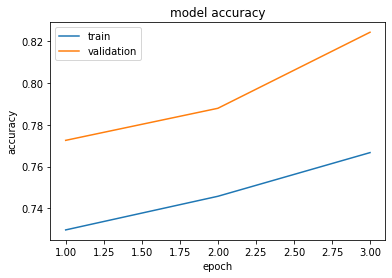

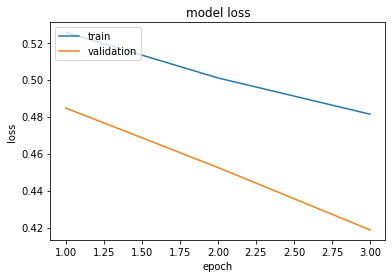

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline 
epochs=[1,2,3]
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(epochs, history.history['acc'])
plt.plot( epochs, history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Constructing the modified convolution model

In [0]:
#convolutional approach
convs = []
filter_sizes = [3,4,5]

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

for fsz in filter_sizes:
    l_conv = Conv1D(nb_filter=128,filter_length=fsz,activation='relu')(embedded_sequences)
    l_pool = MaxPooling1D(5)(l_conv)
    convs.append(l_pool)
    
l_merge = Concatenate(axis=1)(convs)
l_cov1= Conv1D(filters=128, kernel_size=5, activation='relu')(l_merge)
l_pool1 = MaxPooling1D(5)(l_cov1)
l_cov2 = Conv1D(filters=128, kernel_size=5, activation='relu')(l_pool1)
l_pool2 = MaxPooling1D(30)(l_cov2)
l_flat = Flatten()(l_pool2)
l_dense = Dense(128, activation='relu')(l_flat)
preds = Dense(2, activation='softmax')(l_dense)

model2 = Model(sequence_input, preds)
model2.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['acc'])
model2.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 1000)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1000, 100)    25187700    input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 998, 128)     38528       embedding_1[1][0]                
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 997, 128)     51328       embedding_1[1][0]                
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=3)`
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=4)`
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=5)`
  if __name__ == '__main__':


### Trainig the model

In [0]:
print("Fitting a more complex convolutional neural network model")
#model2.summary()
epochs=range(1,6)
history2 = model2.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=5, batch_size=50)
model2.save('model.h5')

Fitting a more complex convolutional neural network model


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 13312 samples, validate on 3328 samples
Epoch 1/5
13312/13312 [==============================] - 30s 2ms/step - loss: 0.5498 - acc: 0.7115 - val_loss: 0.3389 - val_acc: 0.8486
Epoch 2/5
13312/13312 [==============================] - 28s 2ms/step - loss: 0.1941 - acc: 0.9214 - val_loss: 0.1138 - val_acc: 0.9582
Epoch 3/5
13312/13312 [==============================] - 28s 2ms/step - loss: 0.0943 - acc: 0.9654 - val_loss: 0.2221 - val_acc: 0.9201
Epoch 4/5
13312/13312 [==============================] - 28s 2ms/step - loss: 0.0426 - acc: 0.9863 - val_loss: 0.1030 - val_acc: 0.9630
Epoch 5/5
13312/13312 [==============================] - 28s 2ms/step - loss: 0.0145 - acc: 0.9950 - val_loss: 0.1227 - val_acc: 0.9694


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


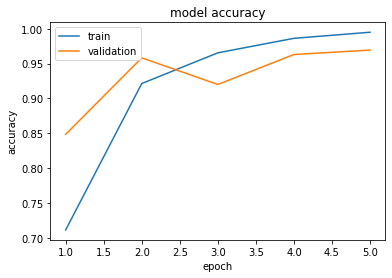

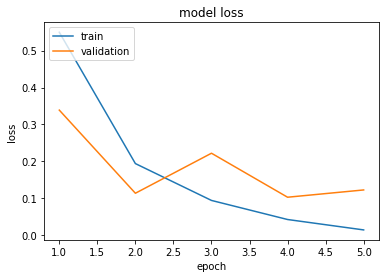

In [0]:
# list all data in history
print(history2.history.keys())
import matplotlib.pyplot as plt
%matplotlib inline 
# summarize history for accuracy
plt.plot(epochs, history2.history['acc'])
plt.plot(epochs,history2.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(epochs, history2.history['loss'])
plt.plot(epochs, history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Correct predictions: 3460.0
Total number of test examples: 4160
Accuracy of model1:  0.8317307692307693
Correct predictions: 4015.0
Total number of test examples: 4160
Accuracy of model2:  0.9651442307692307


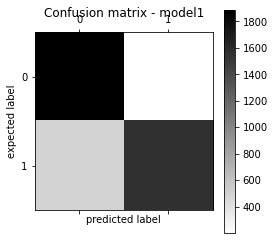

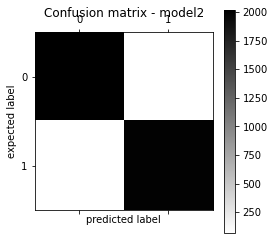

In [0]:
# Test model 1
test_preds = model.predict(x_test)
test_preds = np.round(test_preds)
correct_predictions = float(sum(test_preds == y_test)[0])
print("Correct predictions:", correct_predictions)
print("Total number of test examples:", len(y_test))
print("Accuracy of model1: ", correct_predictions/float(len(y_test)))

# Creating the Confusion Matrix
from sklearn.metrics import confusion_matrix
x_pred = model.predict(x_test)
x_pred = np.round(x_pred)
x_pred = x_pred.argmax(1)
y_test_s = y_test.argmax(1)
cm = confusion_matrix(y_test_s, x_pred)
plt.matshow(cm, cmap=plt.cm.binary, interpolation='nearest')
plt.title('Confusion matrix - model1')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')
# plt.show()

#Test model 2
test_preds2 = model2.predict(x_test)
test_preds2 = np.round(test_preds2)
correct_predictions = float(sum(test_preds2 == y_test)[0])
print("Correct predictions:", correct_predictions)
print("Total number of test examples:", len(y_test))
print("Accuracy of model2: ", correct_predictions/float(len(y_test)))

# Creating the Confusion Matrix
x_pred = model2.predict(x_test)
x_pred = np.round(x_pred)
x_pred = x_pred.argmax(1)
y_test_s = y_test.argmax(1)
cm = confusion_matrix(y_test_s, x_pred)
plt.matshow(cm, cmap=plt.cm.binary, interpolation='nearest',)
plt.title('Confusion matrix - model2')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')
plt.show()

In [0]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.39431399198678824
Test accuracy: 0.8317307829856873


In [0]:
score = model2.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.15221158607782853
Test accuracy: 0.9651442170143127


# LSTM Model

LSTM BASED ARCHITECTURE  -

*   based LSTM cells which are a type of recurrent neurons that have probed to  sequence modeling as  It is needed when working on NLP problems.
*   composed of several gates in charge of maintaining a hidden cell state which allows them to mitigate the vanishing gradient problem.
* This feature it’s important in the context of NLP since the words from the past often influence the current ones.

In [0]:
MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 200000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

In [0]:
data_train.head(5)

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [0]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, GRU
from keras.layers.normalization import BatchNormalization

In [0]:
embedding_vecor_length = 32
modell = Sequential()
modell.add(embedding_layer)
modell.add(Dropout(0.2))
modell.add(Conv1D(filters=32, kernel_size=5, padding='same', activation='relu'))
modell.add(MaxPooling1D(pool_size=2))
modell.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
modell.add(MaxPooling1D(pool_size=2))
modell.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
modell.add(BatchNormalization())
modell.add(Dense(256, activation='relu'))
modell.add(Dense(128, activation='relu'))
modell.add(Dense(64, activation='relu'))
modell.add(Dense(2, activation='softmax'))
modell.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(modell.summary())


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 100)         25187700  
_________________________________________________________________
dropout_3 (Dropout)          (None, 1000, 100)         0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 1000, 32)          16032     
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 500, 32)           0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 500, 64)           6208      
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 250, 64)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)              

In [0]:
modell.fit(x_train, y_train, epochs=10, batch_size=64)

modell.save('lstm.h5')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/10
13312/13312 [==============================] - 174s 13ms/step - loss: 0.3885 - accuracy: 0.8143
Epoch 2/10
13312/13312 [==============================] - 170s 13ms/step - loss: 0.2012 - accuracy: 0.9210
Epoch 3/10
13312/13312 [==============================] - 171s 13ms/step - loss: 0.1387 - accuracy: 0.9455
Epoch 4/10
13312/13312 [==============================] - 173s 13ms/step - loss: 0.0887 - accuracy: 0.9711
Epoch 5/10
13312/13312 [==============================] - 171s 13ms/step - loss: 0.0733 - accuracy: 0.9738
Epoch 6/10
13312/13312 [==============================] - 174s 13ms/step - loss: 0.0383 - accuracy: 0.9872
Epoch 7/10
13312/13312 [==============================] - 174s 13ms/step - loss: 0.0506 - accuracy: 0.9821
Epoch 8/10
13312/13312 [==============================] - 174s 13ms/step - loss: 0.0208 - accuracy: 0.9934
Epoch 9/10
13312/13312 [==============================] - 174s 13ms/step - loss: 0.0153 - accuracy: 0.9954
Epoch 10/10
13312/13312 [============

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Correct predictions: 4010.0
Total number of test examples: 4160
Accuracy of model1:  0.9639423076923077


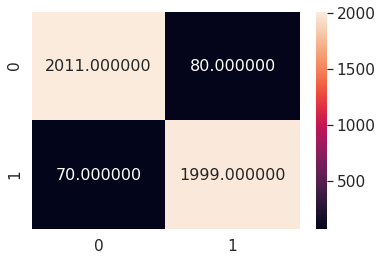

In [0]:
import seaborn as sns
test_preds = modell.predict(x_test)
test_preds = np.round(test_preds)
correct_predictions = float(sum(test_preds == y_test)[0])
print("Correct predictions:", correct_predictions)
print("Total number of test examples:", len(y_test))
print("Accuracy of model1: ", correct_predictions/float(len(y_test)))

x_pred = modell.predict(x_test)
x_pred = np.round(x_pred)
x_pred = x_pred.argmax(1)
y_test_s = y_test.argmax(1)
cm = confusion_matrix(y_test_s, x_pred)

sns.set(font_scale=1.4)#for label size
sns.heatmap(cm,annot=True,annot_kws={"size": 16},fmt='1f')# font size

From above confucion matrix we can see that out of 2091 fake news data, the model is identifying 2011 data as fake, whick is approximately 95% of total fake news data, and for true news it is classifying correctly 96.6% of real news data.

# Conclusion
We observed that LSTM is performing better than CNN model because It handles data sequentially and NLP problem are sequential in nature and also it has ability to remember more distant information in the past which is  drawback in the case of CNN model